## Stable Diffusion on SPR with IPEX

This is a demo of [Stable Diffusion with the Hugging Face API](https://huggingface.co/stabilityai), and using the [Intel Extension for PyTorch](https://github.com/intel/intel-extension-for-pytorch) (IPEX) to optimize the model pipeline on Intel's 4th generation Xeon platform.

The demo consists of the following steps:

1. Load and define the core SD model components from HF.
2. Set up and run a standard SD pipeline with the HF API, i.e., generate a FP32 precision image.
3. Optimize SD with IPEX, using Auto Mixed Precision (BF16), and run the pipeline again.
4. Compare the results wrt inference latency time.

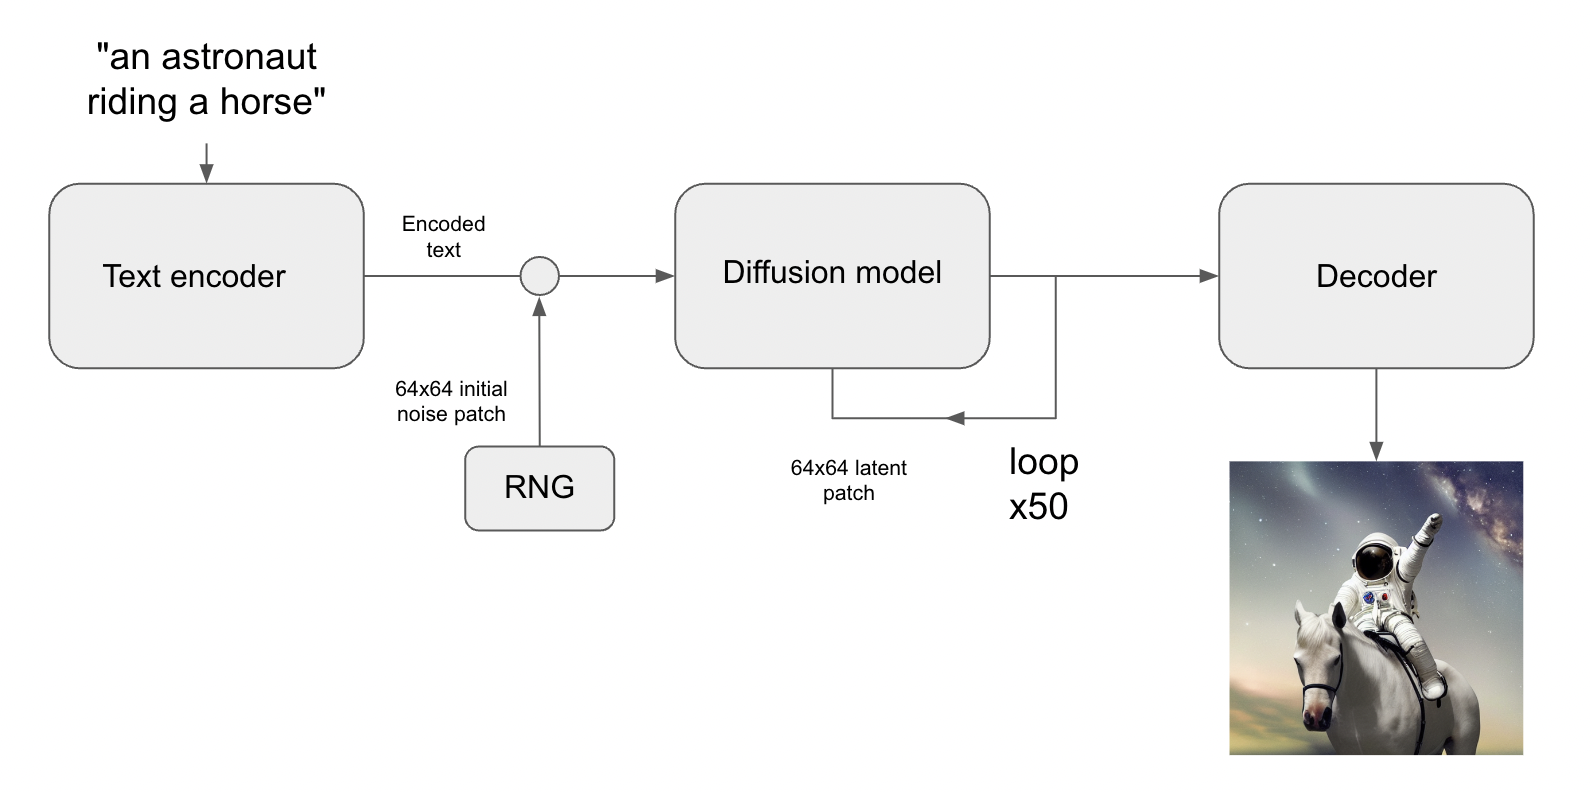

image-credits: https://keras.io/examples/generative/random_walks_with_stable_diffusion/

**This demo is executed in a Conda\* environment.**

The environment is the latest [Intel® oneAPI AI Analytics Toolkit](https://software.intel.com/content/www/us/en/develop/tools/oneapi/ai-analytics-toolkit.html) PyTorch* environment, which includes Intel® Optimizations for deep learning workflows. See [here](https://software.intel.com/content/www/us/en/develop/articles/installing-ai-kit-with-conda.html) for more installation information.

If not yet installed, please make sure to uncomment the following line in order to install Diffusers, Transformers, and update Torch and IPEX.

In [1]:
# ! pip install -U diffusers transformers torch intel_extension_for_pytorch matplotlib

#### Validate the environment by doing version check

##### Collect Hardware info

In [2]:
%cat /proc/cpuinfo | head -n 10

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 143
model name	: Intel(R) Xeon(R) Platinum 8480+
stepping	: 6
microcode	: 0x2b000081
cpu MHz		: 2000.000
cache size	: 107520 KB
physical id	: 0
cat: write error: Broken pipe


##### Collect Software info

In [3]:
import torch.utils.collect_env as environ

print(environ.main())

/home/sdp/anaconda3/envs/sd_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PyTorch version: 1.13.1
Is debug build: False
CUDA used to build PyTorch: None
ROCM used to build PyTorch: N/A

OS: Ubuntu 22.04.1 LTS (x86_64)
GCC version: (Ubuntu 11.3.0-1ubuntu1~22.04) 11.3.0
Clang version: Could not collect
CMake version: Could not collect
Libc version: glibc-2.35

Python version: 3.9.16 (main, Mar  8 2023, 14:00:05)  [GCC 11.2.0] (64-bit runtime)
Python platform: Linux-5.15.0-57-generic-x86_64-with-glibc2.35
Is CUDA available: False
CUDA runtime version: No CUDA
CUDA_MODULE_LOADING set to: N/A
GPU models and configuration: No CUDA
Nvidia driver version: No CUDA
cuDNN version: No CUDA
HIP runtime version: N/A
MIOpen runtime version: N/A
Is XNNPACK available: True

Versions of relevant libraries:
[pip3] intel-extension-for-pytorch==1.13.100
[pip3] numpy==1.23.5
[pip3] torch==1.13.1
[pip3] torchaudio==0.13.1
[pip3] torchvision==0.14.1
[conda] blas                      1.0                         mkl  
[conda] cpuonly                   2.0                           0 

### Import necessary packages

In [4]:
import torch

from diffusers import AutoencoderKL, DDPMScheduler, PNDMScheduler, DPMSolverMultistepScheduler, EulerDiscreteScheduler, StableDiffusionPipeline, UNet2DConditionModel
from diffusers.optimization import get_scheduler
from diffusers.pipelines.stable_diffusion import StableDiffusionSafetyChecker

from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer

import matplotlib.pyplot as plt

import time

Also, we need to register the usage of SD with our personal HF API token. Please paste your token either directly in the cell, or load it from a file. 

In [5]:
# My token
# MY_TOKEN = 'my_hf_api_token'
with open('hf_api.txt') as f:
    MY_TOKEN=f.read()

Please uncomment the following line if verbose oneDNN logging is wanted.

In [6]:
# %env ONEDNN_VERBOSE=1

### Load pretrained SD model components

Next, we load the various pretrained SD model core components from the HF hub:
- The CLIP text tokenizer.
- The CLIP text encoder.
- The UNET.
- And the Autoencoder.

In [7]:
# Define model ID for SD version
model_id = "CompVis/stable-diffusion-v1-4"
# model_id = "stabilityai/stable-diffusion-2-1"

# Load models and create wrapper for stable diffusion
tokenizer = CLIPTokenizer.from_pretrained(model_id, subfolder="tokenizer", use_auth_token=MY_TOKEN)
text_encoder = CLIPTextModel.from_pretrained(model_id, subfolder="text_encoder", use_auth_token=MY_TOKEN)
unet = UNet2DConditionModel.from_pretrained(model_id, subfolder="unet", use_auth_token=MY_TOKEN)
vae = AutoencoderKL.from_pretrained(model_id, subfolder="vae", use_auth_token=MY_TOKEN)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


### Construct SD Pipeline

Next, we construct the SD pipeline with the HF API. For different performances, experiment, e.g., with the scheduler, and its parameters.

In [8]:
scheduler=PNDMScheduler(beta_start=0.00085, 
                        beta_end=0.012, 
                        beta_schedule="scaled_linear", 
                        skip_prk_steps=True, 
                        steps_offset=1)
# scheduler=DPMSolverMultistepScheduler.from_config(scheduler.config)
# scheduler = EulerDiscreteScheduler.from_pretrained(model_id, subfolder="scheduler")

pipeline = StableDiffusionPipeline(
    text_encoder=text_encoder,
    vae=vae,
    unet=unet,
    tokenizer=tokenizer,
    scheduler=scheduler,
    safety_checker=StableDiffusionSafetyChecker.from_pretrained("CompVis/stable-diffusion-safety-checker"),
    feature_extractor=CLIPFeatureExtractor.from_pretrained("openai/clip-vit-base-patch32"))

/home/sdp/anaconda3/envs/sd_env/lib/python3.9/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


### **Single image inference**

Then, we call the pipeline with a written description of the wanted image, i.e., the text prompt. And generate an image.

The inference process can be made deterministic by setting the generator seed. Furthermore, through the number of inference steps, we can govern the quality of the image, i.e., more steps equals better quality. Reduce the number of steps to receive results faster.

Please experiment with your own prompts!

In [9]:
# Define the prompt for the image generation
prompt = "Painting of a frog with hat on a bicycle cycling in New York City at a beautiful dusk with a traffic jam and moody people in the style of Picasso"

# Set the number of iterations for the image generation
n_inf_steps = 20

# Setting seed for deterministic output
seed = 701
generator = torch.Generator("cpu").manual_seed(seed)

# Simple timing of inference
start = time.time()
image = pipeline(prompt, num_inference_steps=n_inf_steps, generator=generator).images[0]
end = time.time()
sd_fp32_t = end-start
print(f"Generating one FP32 image took {round(sd_fp32_t, 2)}s")

image.save("frog_test_FP32.png")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:59<00:00,  2.95s/it]


Generating one FP32 image took 61.89s


### **Optimization with IPEX**

The UNET component of the model architecture is the one that uses most computational resources in the inference process. Hence, with IPEX, we optimize it, and put it in BF16 precision.
Please note: Experiment also with the optimization of the text encoder.

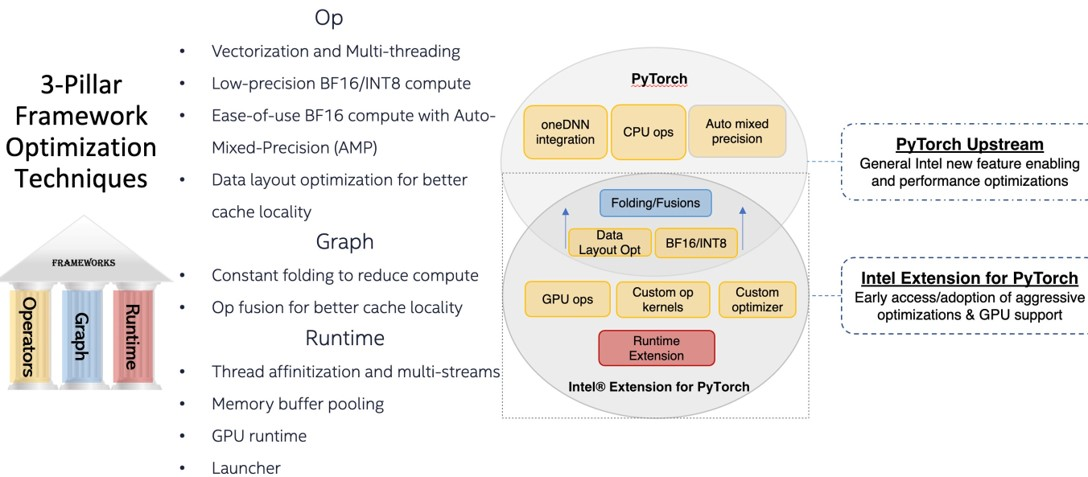

### Import IPEX

In [10]:
import intel_extension_for_pytorch as ipex

# Put model in eval mode.
unet.eval()
# text_encoder.eval()

# Optimize the model w/ IPEX
unet = ipex.optimize(unet, dtype=torch.bfloat16)
# text_encoder = ipex.optimize(text_encoder, dtype=torch.bfloat16)

/home/sdp/anaconda3/envs/sd_env/lib/python3.9/site-packages/intel_extension_for_pytorch/frontend.py:427: UserWarning: Conv BatchNorm folding failed during the optimize process.
  warnings.warn("Conv BatchNorm folding failed during the optimize process.")
/home/sdp/anaconda3/envs/sd_env/lib/python3.9/site-packages/intel_extension_for_pytorch/frontend.py:432: UserWarning: Linear BatchNorm folding failed during the optimize process.
  warnings.warn("Linear BatchNorm folding failed during the optimize process.")


### Construct SD Pipeline

In [11]:
scheduler=PNDMScheduler(beta_start=0.00085, 
                        beta_end=0.012, 
                        beta_schedule="scaled_linear", 
                        skip_prk_steps=True, 
                        steps_offset=1)

pipeline = StableDiffusionPipeline(
    text_encoder=text_encoder,
    vae=vae,
    unet=unet,
    tokenizer=tokenizer,
    scheduler=scheduler,
    safety_checker=StableDiffusionSafetyChecker.from_pretrained("CompVis/stable-diffusion-safety-checker"),
    feature_extractor=CLIPFeatureExtractor.from_pretrained("openai/clip-vit-base-patch32"))

/home/sdp/anaconda3/envs/sd_env/lib/python3.9/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


### Single image inference with IPEX

In [12]:
generator = torch.Generator("cpu").manual_seed(seed)

# Simple timing of inference
start = time.time()
with torch.cpu.amp.autocast():
    image = pipeline(prompt, num_inference_steps=n_inf_steps, generator=generator).images[0]
end = time.time()
sd_bf16_t = end-start
print(f"Generating one BF16 image took {round(sd_bf16_t, 2)}s")

image.save("frog_test_BF16.png")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.39s/it]


Generating one BF16 image took 29.23s


We compare the inference speeds between the two runs.

In [13]:
print(f"Inference with IPEX, using AMP+BF16, was {round(sd_fp32_t/sd_bf16_t, 2)}x faster.")

Inference with IPEX, using AMP+BF16, was 2.12x faster.


In [14]:
def plotter(outputdict):
    fig = plt.figure(figsize = (10, 5)) 
    plt.bar(outputdict.keys(),outputdict.values(),color=['#ffd21e', '#0071c5'],width=0.4)
    plt.xlabel("Model")
    plt.ylabel("Eval inference (seconds); lower is better")
    plt.show()

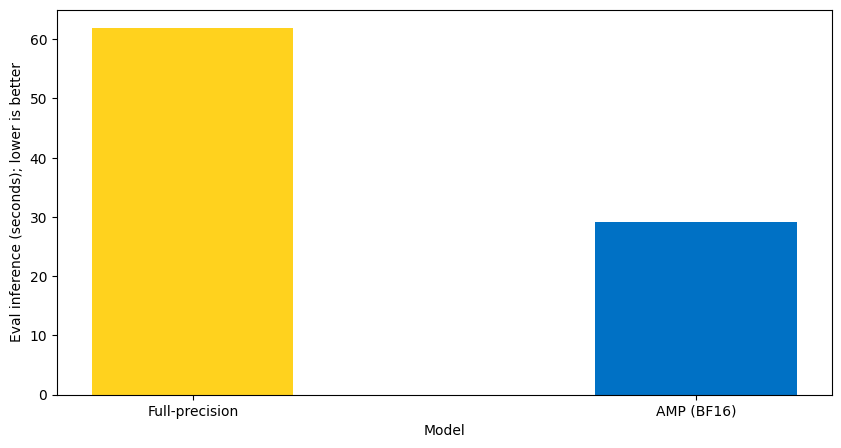

In [15]:
outputDict={"Full-precision":sd_fp32_t,"AMP (BF16)":sd_bf16_t}
plotter(outputDict)

**Batched inference**

Finally, we generate a batch of 3 images, and compare the performance.

In [16]:
from PIL import Image

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

In [17]:
num_images = 3

prompt = ["Painting of a frog with hat on a bicycle cycling in New York City at a beautiful dusk with a traffic jam and moody people in the style of Picasso"] * num_images

start = time.time()
with torch.cpu.amp.autocast():
    images = pipeline(prompt, num_inference_steps=n_inf_steps).images
end = time.time()
sd_bbf16_t = end-start
print(f"Generating {num_images} BF16 images took {round(sd_bbf16_t, 2)}s. Per image inference time: {round(sd_bbf16_t/num_images, 2)}s.")

grid = image_grid(images, rows=1, cols=3)

grid.save(f"frog_batch.png")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:18<00:00,  3.94s/it]


Generating 3 BF16 images took 81.82s. Per image inference time: 27.27s.
